<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Create-the-graph" data-toc-modified-id="Create-the-graph-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Create the graph</a></span><ul class="toc-item"><li><span><a href="#Create-the-nodes" data-toc-modified-id="Create-the-nodes-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Create the nodes</a></span></li><li><span><a href="#Create-the-edges" data-toc-modified-id="Create-the-edges-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Create the edges</a></span></li></ul></li><li><span><a href="#Draw-Graph" data-toc-modified-id="Draw-Graph-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Draw Graph</a></span></li><li><span><a href="#Calculate-Pagerank" data-toc-modified-id="Calculate-Pagerank-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Calculate Pagerank</a></span></li></ul></div>

# Network X Tutorial

Link to [original tutorial](https://networkx.github.io/documentation/networkx-1.10/tutorial/tutorial.html)

In [1]:
# Import libraries
import numpy as np
import pandas as pd
from tqdm import tqdm

import networkx as nx

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns 
# sns.set_style('whitegrid')
color = 'rebeccapurple'
%matplotlib inline

# Display settings
from IPython.display import display
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100

In [2]:
# Read data
rules = pd.read_csv('data/interim/rules.csv')

# Transform first two columns to list format
for col in ['antecedents', 'consequents']:
    rules[col] = rules[col]\
            .str.strip('frozenset({})').str.replace("'", "").str.replace(" ", "")
    rules[col] = rules[col].str.split(',')

NOTE TO MYSELF: I should not have transformed these columns to list format. This unnecessarily complicates the code in the next sections. But anyway, I left it as it is.

In [3]:
# Check data
print(rules.info())
display(rules.sample(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 972 entries, 0 to 971
Data columns (total 9 columns):
antecedents           972 non-null object
consequents           972 non-null object
antecedent support    972 non-null float64
consequent support    972 non-null float64
support               972 non-null float64
confidence            972 non-null float64
lift                  972 non-null float64
leverage              972 non-null float64
conviction            972 non-null float64
dtypes: float64(7), object(2)
memory usage: 68.4+ KB
None


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
115,[5074218],[5074219],0.007247,0.004949,0.004949,0.682832,137.979631,0.004913,3.137302
491,"[2806480, 2806409]",[2809116],0.001441,0.001462,0.001441,1.000000,683.927885,0.001439,inf
5,[2310724],[2310723],0.002292,0.002067,0.001188,0.518405,250.839207,0.001183,2.072142
6,[2310723],[2310724],0.002067,0.002292,0.001188,0.574830,250.839207,0.001183,2.346610
224,[6103405],[6115020],0.003627,0.009265,0.001195,0.329457,35.559648,0.001161,1.477512


## Create the graph

documentation for [basic graph types](https://networkx.github.io/documentation/networkx-1.10/reference/classes.html)

In [4]:
# Initialize empty directed graph
G = nx.DiGraph()

### Create the nodes

**DECISION**: Every unique occurence of antecedents and / or consequents will be a node. So there will be nodes that represent groups of multiple products. I will try to visualize this with different colors.

In [5]:
# Check for number of different elements in antecedents and consequents
# This is a bit tricky because of the list format of cell values

s1 = set(rules['antecedents'].apply(lambda x: str(x)))
s2 = set(rules['consequents'].apply(lambda x: str(x)))
diff = s1.difference(s2)
print(len(diff))

125


In [6]:
# Make a list of all antecedents and consequents without duplicates
# This is a bit tricky because of the list format of cell values
# Note it may be that there are still some duplicates remaining if some lists elements are not in same order

nodes_df = pd.DataFrame(pd.concat([rules['antecedents'], rules['consequents']], 
                                  ignore_index=True, sort=True))
assert len(nodes_df) == 2*len(rules)
nodes_df['temp'] = nodes_df[0].apply(lambda x: str(x)) # need this for identifying duplicates
nodes_df.drop_duplicates(subset='temp', inplace=True)
print("Unique nodes for our graph:", len(nodes_df))

# Add column with number of items in every cell (will be used as node property)
nodes_df['len'] = nodes_df[0].apply(len)

Unique nodes for our graph: 489


In [7]:
# Check the results
nodes_df.sample(5)

,0,temp,len
1065,[5047371],['5047371'],1
1,[2119623],['2119623'],1
612,"[6115230, 6202306]","['6115230', '6202306']",2
1364,[8530460],['8530460'],1
614,"[6115230, 6202406]","['6115230', '6202406']",2


In [11]:
# Create a list of node tuples (with n items as attribute)
nodes = list(zip(nodes_df['temp'], nodes_df['len']))

G.clear()

# Add notes to graph
for n in nodes:
    G.add_node(n[0], n_items=n[1])

In [12]:
# Check results, look at 5 nodes of the graph
list(G.nodes(data=True))[-5:]

[("['8600103']", {'n_items': 1}),
 ("['8609001']", {'n_items': 1}),
 ("['8633101']", {'n_items': 1}),
 ("['8641501']", {'n_items': 1}),
 ("['6115231', '6115230', '6113401']", {'n_items': 3})]

### Create the edges

We will take the confidence measure as weight for the edges as this is a directed measure.

In [16]:
# Create an 'ebunch' of edges (iterable container of edge-tuples)

edges = []

for row in rules[['antecedents', 'consequents', 'confidence']].itertuples(index=False, name=None):
    x1 = str(row[0])
    x2 = str(row[1])
    x3 = {'weight': row[2]}
    edges.append((x1, x2, x3))

In [18]:
# Add edges to graph
G.add_edges_from(edges)

## Draw Graph

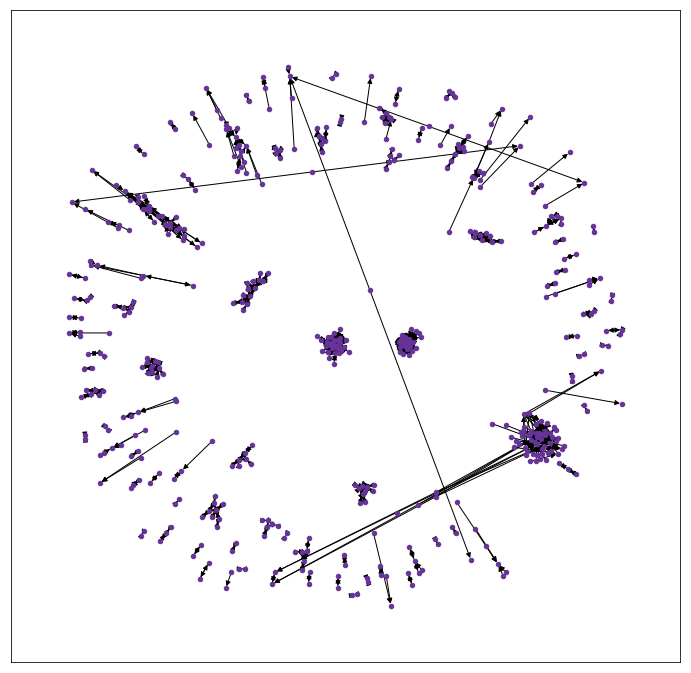

In [35]:
plt.figure(figsize=(12, 12))
nx.draw_networkx(G, pos=nx.spring_layout(G), node_size=20, with_labels=False, node_color=color)

**Open Question:** What is the effect of having nodes with multiple items? Could the picture be clearer if I had only pairwise itemsets included?

## Calculate Pagerank

In [41]:
pr = nx.pagerank_numpy(G)
pr_sorted = sorted(pr.items(), key=lambda x: x[1], reverse=True)

In [43]:
pr_sorted[:5]

[("['6113401']", 0.031044672890705022),
 ("['6115230']", 0.030568294389863557),
 ("['6115231']", 0.025273541455242025),
 ("['6115020']", 0.01617908537782118),
 ("['6115032']", 0.008777786670084123)]

**Open Question:** What is the effect of the edge weights?